In [3]:
import numpy as np 
import pandas as pd
pd.options.mode.chained_assignment = None
from scipy.optimize import newton
from scipy.optimize import brentq
from datetime import datetime, timedelta
from dateutil.relativedelta import *
import matplotlib.pyplot as plt

In [4]:
def str_to_time(a):
    try:
        return datetime.strptime(a, '%Y/%m/%d')
    except:
        return np.nan
    
def trunc_datetime(date):
    return date.replace(day=1, year=2020)

In [5]:
df_raw = pd.read_csv('a1_raw.csv')
df_date = pd.read_csv('date.csv').dropna()
df_raw

,ISIN,coupon,issue_date,maturity_date,price_jan_10,price_jan_11,price_jan_12,price_jan_13,price_jan_14,price_jan_17,price_jan_18,price_jan_19,price_jan_20,price_jan_21
0,K601,0.0150,2019/11/4,2022/2/1,100.070,100.06,100.060,100.050,100.040,100.04,100.030,100.030,100.020,100.020
1,L286,0.0025,2020/5/4,2022/8/1,99.800,99.79,99.780,99.770,99.760,99.72,99.700,99.700,99.720,99.740
2,L773,0.0025,2020/10/26,2023/2/1,99.310,99.26,99.290,99.280,99.260,99.18,99.120,99.100,99.150,99.200
3,M359,0.0025,2021/5/14,2023/8/1,98.808,98.80,98.781,98.763,98.736,98.61,98.553,98.549,98.558,98.611
4,J546,0.0225,2018/10/5,2024/3/1,102.310,102.31,102.260,102.220,102.180,101.99,101.910,101.900,101.880,101.970
5,J967,0.0150,2019/4/5,2024/9/1,100.560,100.63,100.620,100.580,100.520,100.29,100.210,100.150,100.170,100.270
6,K528,0.0125,2019/10/11,2025/3/1,99.640,99.67,99.610,99.590,99.490,99.25,99.120,99.110,99.100,99.260
7,K940,0.0050,2020/4/3,2025/9/1,96.660,96.72,96.770,96.770,96.680,96.43,96.260,96.150,96.190,96.310
8,L518,0.0025,2020/10/9,2026/3/1,95.110,95.17,95.120,95.140,95.040,94.75,94.530,94.500,94.520,94.700
9,L930,0.0100,2021/4/16,2026/9/1,97.660,97.70,97.670,97.690,97.580,97.24,97.020,96.960,97.000,97.225


In [6]:
df_date = df_date.applymap(str_to_time) # func apply to each element
lst_date = ['jan_10', 'jan_11', 'jan_12', 'jan_13', 'jan_14', 'jan_17', 'jan_18', 'jan_19', 'jan_20', 'jan_21']
df = df_raw.join(df_date).set_index('ISIN')
df[['issue_date', 'maturity_date']] = df[['issue_date', 'maturity_date']].applymap(str_to_time)

Caculation started

Dirty Price Calculation

In [7]:
def dirty_price(current_price, coupon_rate, current_date, maturity_date, fv=100, year=365, freq=2):
    # first find the date before current_date that issues bond
    # preconditons: current_date < maturity_date
    recent_issue_date = maturity_date
    
#     print(type(recent_issue_date), recent_issue_date)
#     print(type(current_date), current_date)

    while (recent_issue_date:= recent_issue_date - relativedelta(months=12/freq)) > current_date:
        continue
    ai = fv * (coupon_rate/freq) * ((current_date-recent_issue_date).days/(year/freq))
    return ai + current_price

In [8]:
lst_priceBdate = ['price_'+i for i in lst_date]
df_dirty = pd.DataFrame(index=df.index.values, columns=['coupon', 'maturity_date'] + lst_priceBdate)
df_dirty[['coupon', 'maturity_date']] = df[['coupon', 'maturity_date']]

for d in lst_date:
    pBdate = 'price_'+d
    df_dirty[pBdate] = df.apply(lambda x: dirty_price(x[pBdate], x['coupon'], x[d], x['maturity_date']), axis=1)
    
df_dirty

,coupon,maturity_date,price_jan_10,price_jan_11,price_jan_12,price_jan_13,price_jan_14,price_jan_17,price_jan_18,price_jan_19,price_jan_20,price_jan_21
K601,0.0150,2022-02-01,100.735753,100.729863,100.733973,100.728082,100.722192,100.734521,100.728630,100.732740,100.726849,100.730959
L286,0.0025,2022-08-01,99.910959,99.901644,99.892329,99.883014,99.873699,99.835753,99.816438,99.817123,99.837808,99.858493
L773,0.0025,2023-02-01,99.420959,99.371644,99.402329,99.393014,99.373699,99.295753,99.236438,99.217123,99.267808,99.318493
M359,0.0025,2023-08-01,98.918959,98.911644,98.893329,98.876014,98.849699,98.725753,98.669438,98.666123,98.675808,98.729493
J546,0.0225,2024-03-01,103.117534,103.123699,103.079863,103.046027,103.012192,102.840685,102.766849,102.763014,102.749178,102.845342
J967,0.0150,2024-09-01,101.098356,101.172466,101.166575,101.130685,101.074795,100.857123,100.781233,100.725342,100.749452,100.853562
K528,0.0125,2025-03-01,100.088630,100.122055,100.065479,100.048904,99.952329,99.722603,99.596027,99.589452,99.582877,99.746301
K940,0.0050,2025-09-01,96.839452,96.900822,96.952192,96.953562,96.864932,96.619041,96.450411,96.341781,96.383151,96.504521
L518,0.0025,2026-03-01,95.199726,95.260411,95.211096,95.231781,95.132466,94.844521,94.625205,94.595890,94.616575,94.797260
L930,0.0100,2026-09-01,98.018904,98.061644,98.034384,98.057123,97.949863,97.618082,97.400822,97.343562,97.386301,97.614041


In [9]:
df_dirty = df_dirty.reset_index().join(df_date)
df_dirty.set_index('index', inplace=True)

YTM Calculation

In [10]:
def present_value(ytm, coupon_rate, current_date, maturity_date, fv=100, year=365, freq=2):
    pv = 0
    total_period = 0
    c = coupon_rate * fv/freq # c is coupon payment for each period
    recent_issue_date = maturity_date
      
    # Counting total # of periods of coupon payment
    while recent_issue_date > current_date:

        recent_issue_date = recent_issue_date - relativedelta(months=12/freq)
        total_period += 1
        continue
    
    # ratio of (current_date-last_payment_date)/total days in the a payment period
    t_ratio = ((current_date-recent_issue_date).days/(recent_issue_date + relativedelta(months=12/freq)-recent_issue_date).days)
        
    for t in range(1, total_period+1):
        pv += c/np.exp(ytm * t/freq)

    pv += fv/np.exp(ytm * total_period/freq)

    pv = np.exp(ytm * t_ratio/freq) * pv
    
    return pv


# Directly using Geometric sequence sum formula
def present_value_2(ytm, coupon_rate, current_date, maturity_date, fv=100, year=365, freq=2):
    pv = 0
    total_period = 0
    c = coupon_rate * fv/freq # c is coupon payment for each period
    recent_issue_date = maturity_date
    
    # Counting total # of periods of coupon payment
    while recent_issue_date > current_date:

        recent_issue_date = recent_issue_date - relativedelta(months=12/freq)
        total_period += 1
        continue
        
    t_ratio = ((current_date-recent_issue_date).days/(year/freq))
        
    pv = c*(1-np.exp(-ytm/freq))/(1-np.exp(-ytm * total_period/freq)) + fv/np.exp(ytm * total_period/freq)
    
    pv = np.exp(ytm * t_ratio/freq) * pv
    
    return pv

# using newton method
def ytm_solver(pv, coupon_rate, current_date, maturity_date, fv=100, year=365, freq=2, guess=0.005):
    return newton(lambda ytm: present_value(ytm, coupon_rate, current_date, maturity_date, 
                                            fv, year, freq) - pv, guess, rtol=1e-40)

# using brentq method
def ytm_solver_2(pv, coupon_rate, current_date, maturity_date, fv=100, year=365, freq=2, guess=0.005):
    return brentq(lambda ytm: present_value_2(ytm, coupon_rate, current_date, maturity_date, 
                                            fv, year, freq) - pv, -5, 1)


In [11]:
lst_ytmBdate = ['ytm_'+i for i in lst_date]
df_ytm = pd.DataFrame(index=df.index.values, columns=['coupon', 'maturity_date'] + lst_ytmBdate)
df_ytm[['coupon', 'maturity_date']] = df[['coupon', 'maturity_date']]

for d in lst_date:
    ytmBdate = 'ytm_'+d
    pBdate = 'price_'+d
    df_ytm[ytmBdate] = df_dirty.apply(lambda df: ytm_solver(df[pBdate], df['coupon'], df[d], df['maturity_date']), axis=1)
df_ytm

,coupon,maturity_date,ytm_jan_10,ytm_jan_11,ytm_jan_12,ytm_jan_13,ytm_jan_14,ytm_jan_17,ytm_jan_18,ytm_jan_19,ytm_jan_20,ytm_jan_21
K601,0.0150,2022-02-01,0.002365,0.003503,0.002927,0.004214,0.005644,0.003770,0.005576,0.004850,0.007048,0.006323
L286,0.0025,2022-08-01,0.006059,0.006256,0.006455,0.006656,0.006859,0.007666,0.008065,0.008093,0.007745,0.007393
L773,0.0025,2023-02-01,0.009027,0.009521,0.009252,0.009365,0.009575,0.010406,0.011010,0.011227,0.010761,0.010293
M359,0.0025,2023-08-01,0.010191,0.010256,0.010393,0.010525,0.010716,0.011589,0.011981,0.012024,0.011981,0.011646
J546,0.0225,2024-03-01,0.011526,0.011513,0.011733,0.011907,0.012081,0.012936,0.013302,0.013338,0.013421,0.012984
J967,0.0150,2024-09-01,0.012809,0.012538,0.012574,0.012726,0.012954,0.013837,0.014146,0.014378,0.014300,0.013911
K528,0.0125,2025-03-01,0.013640,0.013544,0.013740,0.013806,0.014134,0.014926,0.015356,0.015391,0.015427,0.014902
K940,0.0050,2025-09-01,0.014409,0.014244,0.014108,0.014115,0.014380,0.015123,0.015622,0.015949,0.015842,0.015501
L518,0.0025,2026-03-01,0.014672,0.014527,0.014662,0.014619,0.014883,0.015654,0.016230,0.016317,0.016274,0.015818
L930,0.0100,2026-09-01,0.015193,0.015106,0.015176,0.015134,0.015386,0.016167,0.016672,0.016813,0.016726,0.016216


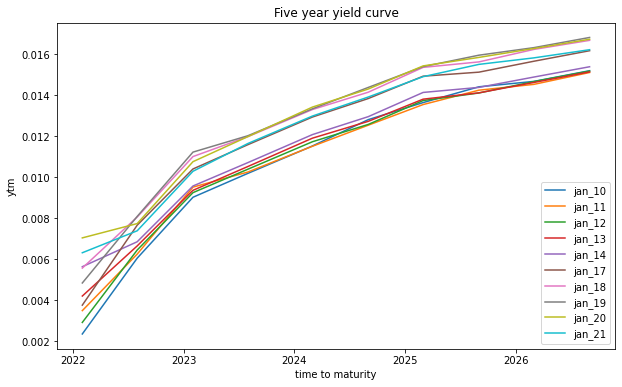

In [12]:
plt.figure(figsize=(10, 6))
plt.xlabel('time to maturity')
plt.ylabel('ytm')
plt.title('Five year yield curve')

for i in range(len(lst_ytmBdate)):
    plt.plot(df_ytm['maturity_date'], df_ytm[lst_ytmBdate[i]], label=lst_date[i])
plt.legend(loc="lower right")

# save first then show
plt.savefig('fig/yield_curve.png', dpi=800)
plt.show()
plt.close()

Spot rate Calculation

In [13]:
def spot_to_price(target_spot, lst_spot, coupon_rate, current_date, maturity_date, fv=100, year=365, freq=2):
    c = coupon_rate * fv/freq
    pv = 0
    
    recent_issue_date = maturity_date
    
    while (recent_issue_date:= recent_issue_date - relativedelta(months=12/freq)) > current_date:
        continue
    
    # ratio of (current_date-last_payment_date)/total days in the a payment period
    t_ratio = ((current_date-recent_issue_date).days/(recent_issue_date + relativedelta(months=12/freq)-recent_issue_date).days)
    
    for i in range(1, len(lst_spot)+1):
        pv += c * np.exp((t_ratio - i)/freq * lst_spot[i-1])
    
    pv += c * np.exp(target_spot*(t_ratio - len(lst_spot)-1)/freq)
    pv += fv * np.exp(target_spot*(t_ratio - len(lst_spot)-1)/freq)
    
    # print('price', pv)
    return pv


def spot_rate_solver(pv, lst_spot, coupon_rate, current_date, maturity_date, fv=100, year=365, freq=2, guess=0.01):
    
    return newton(lambda target_spot: spot_to_price(target_spot, lst_spot, coupon_rate, current_date, maturity_date, 
                                                    fv=100, year=365, freq=2) - pv, guess, rtol=1e-40)

Create df storing spot rates

In [14]:
lst_spotBdate = ['spot_'+i for i in lst_date]
df_spot = pd.DataFrame(index=df.index.values, columns=['coupon', 'maturity_date'] + lst_spotBdate)
df_spot[['coupon', 'maturity_date']] = df[['coupon', 'maturity_date']]
df_spot.loc['K601'] = df_ytm.loc['K601'].values
df_spot = df_spot.reset_index().drop(columns=['index'])

# separate the df_spot into 2 parts
df_spot_1 = df_spot.loc[0:3]
df_spot_2 = df_spot.loc[4:9]

In [15]:
# Calculate spot rate for df_spot_1   
for d in lst_date:
    
    pBdate = 'price_'+d
    spotBdate = 'spot_'+d
     
    for i in df_spot_1.index: 
        
        if i+1 in df_spot_1.index.values:
            pv = df_dirty.reset_index().loc[i+1, pBdate]
            lst_spot = df_spot_1.loc[:i, spotBdate].values.tolist()
            coupon_rate = df_spot_1.loc[i+1, 'coupon']
            current_date = df_dirty.reset_index().loc[i+1, d]
            maturity_date = df_spot_1.loc[i+1, 'maturity_date']
    #         print(pv, type(pv))
    #         print(lst_spot)
    #         print(coupon_rate)
            a = spot_rate_solver(pv, lst_spot, coupon_rate, current_date, maturity_date).copy()
            df_spot_1.loc[i+1, spotBdate] = a

df_spot_1       

,coupon,maturity_date,spot_jan_10,spot_jan_11,spot_jan_12,spot_jan_13,spot_jan_14,spot_jan_17,spot_jan_18,spot_jan_19,spot_jan_20,spot_jan_21
0,0.0150,2022-02-01,0.002365,0.003503,0.002927,0.004214,0.005644,0.00377,0.005576,0.00485,0.007048,0.006323
1,0.0025,2022-08-01,0.006059,0.006256,0.006455,0.006656,0.006859,0.007666,0.008065,0.008093,0.007745,0.007393
2,0.0025,2023-02-01,0.00903,0.009523,0.009254,0.009367,0.009577,0.010408,0.011012,0.011229,0.010763,0.010295
3,0.0025,2023-08-01,0.010194,0.010259,0.010396,0.010528,0.010718,0.011592,0.011984,0.012027,0.011985,0.01165


Interpolation for df_spot_1

In [16]:
def interopolation(start_d, end_d, target_d, start_p, end_p):
    
    start_d = start_d.timestamp()
    end_d = end_d.timestamp()
    target_d = target_d.timestamp()
    
    return (end_p-start_p)/(end_d-start_d)*(target_d-start_d) + start_p

In [17]:
# group start, end, target date together
def group_date(lst_maturity): 
    
    lst_result = [[lst_maturity[i]+relativedelta(months=1)] for i in range(len(lst_maturity))]

    for i in range(len(lst_maturity)):
        if i+1 < len(lst_maturity):
            lst_result[i].append(lst_maturity[i])
            lst_result[i].append(lst_maturity[i+1])
        else:
            lst_result[i].append(lst_maturity[i-1])
            lst_result[i].append(lst_maturity[i])
           
    return pd.DataFrame(np.array(lst_result), columns=['maturity_date', 'start_date', 'end_date'])

def group_date_2(lst_maturity, lst_result, maturity_date): 

    for i in range(len(lst_maturity)):
        if i+1 < len(lst_maturity):
            lst_result[i].append(lst_maturity[i])
            lst_result[i].append(lst_maturity[i+1])
        else:
            lst_result[i].append(lst_maturity[i-1])
            lst_result[i].append(lst_maturity[i])
            
    # print(maturity_date)
    
    return pd.DataFrame(np.array(lst_result), columns=[maturity_date, 'start_date', 'end_date'])


def group_spot(lst_spot, spotBdate):
    lst_result = [[] for i in range(len(lst_spot))]
    
    for i in range(len(lst_spot)):
        
        if i == 0:
            lst_result[i].append(lst_spot[i])
            lst_result[i].append(lst_spot[i])
        
        elif i+1 < len(lst_spot):
            lst_result[i].append(lst_spot[i])
            lst_result[i].append(lst_spot[i+1])
            
        else:
            lst_result[i].append(lst_spot[i-1])
            lst_result[i].append(lst_spot[i])
           
    return pd.DataFrame(np.array(lst_result), columns=['start_'+spotBdate, 'end_'+spotBdate])

def group_spot_2(lst_spot, spotBdate):
    lst_result = [[] for i in range(len(lst_spot))]
    
    for i in range(len(lst_spot)):
        
        if i+1 < len(lst_spot):
            lst_result[i].append(lst_spot[i])
            lst_result[i].append(lst_spot[i+1])
            
        else:
            lst_result[i].append(lst_spot[i-1])
            lst_result[i].append(lst_spot[i])
           
    return pd.DataFrame(np.array(lst_result), columns=['start_'+spotBdate, 'end_'+spotBdate])
    

In [18]:
df_spot_1_in = df_spot_1.copy()
df_spot_1_in.drop(columns={'maturity_date'}, inplace=True)

lst_maturity = df_spot_1['maturity_date'].tolist()
df_spot_1_in = df_spot_1_in.join(group_date(lst_maturity))

for spotBdate in lst_spotBdate:

    lst_spot = df_spot_1[spotBdate].tolist()
    df_spot_1_in = df_spot_1_in.join(group_spot(lst_spot, spotBdate))
    df_spot_1_in.drop(columns={spotBdate}, inplace=True)
    df_spot_1_in[spotBdate] = df_spot_1_in.apply(lambda df: interopolation(df['start_date'], df['end_date'], df['maturity_date'], 
                                                                df['start_'+spotBdate], df['end_'+spotBdate]), axis=1)

    df_spot_1_in.drop(columns={'start_'+spotBdate, 'end_'+spotBdate}, inplace=True)
    
df_spot_1_in.drop(columns={'start_date', 'end_date'}, inplace=True)    

df_spot_1_in


,coupon,maturity_date,spot_jan_10,spot_jan_11,spot_jan_12,spot_jan_13,spot_jan_14,spot_jan_17,spot_jan_18,spot_jan_19,spot_jan_20,spot_jan_21
0,0.0150,2022-03-01,0.002365,0.003503,0.002927,0.004214,0.005644,0.003770,0.005576,0.004850,0.007048,0.006323
1,0.0025,2022-09-01,0.006560,0.006807,0.006927,0.007113,0.007317,0.008128,0.008562,0.008622,0.008253,0.007882
2,0.0025,2023-03-01,0.009210,0.009637,0.009431,0.009547,0.009754,0.010591,0.011162,0.011353,0.010952,0.010505
3,0.0025,2023-09-01,0.010393,0.010385,0.010592,0.010726,0.010914,0.011794,0.012150,0.012164,0.012194,0.011882


In [19]:
df_spot_3 = pd.concat([df_spot_1_in, df_spot_2])  
# Calculate spot rate for df_spot_3   
for d in lst_date:
    
    pBdate = 'price_'+d
    spotBdate = 'spot_'+d
     
    for i in range(3, len(df_spot_3.index.values)): 
        
        if i+1 in df_spot_3.index.values:
            pv = df_dirty.reset_index().loc[i+1, pBdate]
            lst_spot = df_spot_3.loc[:i, spotBdate].values.tolist()
            coupon_rate = df_spot_3.loc[i+1, 'coupon']
            current_date = df_dirty.reset_index().loc[i+1, d]
            maturity_date = df_spot_3.loc[i+1, 'maturity_date']
    #         print(pv, type(pv))
    #         print(lst_spot)
    #         print(coupon_rate)
            a = spot_rate_solver(pv, lst_spot, coupon_rate, current_date, maturity_date).copy()
            df_spot_3.loc[i+1, spotBdate] = a

df_spot_3

,coupon,maturity_date,spot_jan_10,spot_jan_11,spot_jan_12,spot_jan_13,spot_jan_14,spot_jan_17,spot_jan_18,spot_jan_19,spot_jan_20,spot_jan_21
0,0.0150,2022-03-01,0.002365,0.003503,0.002927,0.004214,0.005644,0.003770,0.005576,0.004850,0.007048,0.006323
1,0.0025,2022-09-01,0.006560,0.006807,0.006927,0.007113,0.007317,0.008128,0.008562,0.008622,0.008253,0.007882
2,0.0025,2023-03-01,0.009210,0.009637,0.009431,0.009547,0.009754,0.010591,0.011162,0.011353,0.010952,0.010505
3,0.0025,2023-09-01,0.010393,0.010385,0.010592,0.010726,0.010914,0.011794,0.012150,0.012164,0.012194,0.011882
4,0.0225,2024-03-01,0.011573,0.011555,0.011779,0.011952,0.012125,0.012982,0.013345,0.013381,0.013467,0.013029
5,0.0150,2024-09-01,0.012855,0.012578,0.012613,0.012764,0.012992,0.013876,0.014183,0.014418,0.014339,0.013950
6,0.0125,2025-03-01,0.013687,0.013588,0.013787,0.013851,0.014181,0.014972,0.015402,0.015436,0.015473,0.014946
7,0.0050,2025-09-01,0.014431,0.014265,0.014127,0.014133,0.014398,0.015140,0.015640,0.015969,0.015861,0.015521
8,0.0025,2026-03-01,0.014683,0.014537,0.014673,0.014630,0.014894,0.015664,0.016241,0.016327,0.016285,0.015828
9,0.0100,2026-09-01,0.015244,0.015156,0.015227,0.015182,0.015434,0.016215,0.016720,0.016861,0.016773,0.016262


In [20]:
df_spot.loc[:3] = df_spot_1
df_spot.loc[4:] = df_spot_3[4:]
df_spot

,coupon,maturity_date,spot_jan_10,spot_jan_11,spot_jan_12,spot_jan_13,spot_jan_14,spot_jan_17,spot_jan_18,spot_jan_19,spot_jan_20,spot_jan_21
0,0.0150,2022-02-01,0.002365,0.003503,0.002927,0.004214,0.005644,0.00377,0.005576,0.00485,0.007048,0.006323
1,0.0025,2022-08-01,0.006059,0.006256,0.006455,0.006656,0.006859,0.007666,0.008065,0.008093,0.007745,0.007393
2,0.0025,2023-02-01,0.00903,0.009523,0.009254,0.009367,0.009577,0.010408,0.011012,0.011229,0.010763,0.010295
3,0.0025,2023-08-01,0.010194,0.010259,0.010396,0.010528,0.010718,0.011592,0.011984,0.012027,0.011985,0.01165
4,0.0225,2024-03-01,0.011573,0.011555,0.011779,0.011952,0.012125,0.012982,0.013345,0.013381,0.013467,0.013029
5,0.0150,2024-09-01,0.012855,0.012578,0.012613,0.012764,0.012992,0.013876,0.014183,0.014418,0.014339,0.01395
6,0.0125,2025-03-01,0.013687,0.013588,0.013787,0.013851,0.014181,0.014972,0.015402,0.015436,0.015473,0.014946
7,0.0050,2025-09-01,0.014431,0.014265,0.014127,0.014133,0.014398,0.01514,0.01564,0.015969,0.015861,0.015521
8,0.0025,2026-03-01,0.014683,0.014537,0.014673,0.01463,0.014894,0.015664,0.016241,0.016327,0.016285,0.015828
9,0.0100,2026-09-01,0.015244,0.015156,0.015227,0.015182,0.015434,0.016215,0.01672,0.016861,0.016773,0.016262


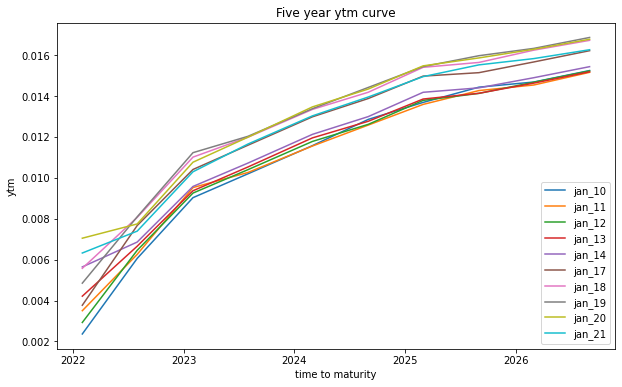

In [21]:
plt.figure(figsize=(10, 6))
plt.xlabel('time to maturity')
plt.ylabel('ytm')
plt.title('Five year ytm curve')

for i in range(len(lst_spotBdate)):
    plt.plot(df_spot['maturity_date'], df_spot[lst_spotBdate[i]], label=lst_date[i])
plt.legend(loc="lower right")

# save first then show
plt.savefig('fig/spot_curve.png', dpi=800)
plt.show()
plt.close()

Intropolation again

In [22]:
lst_datetime = [datetime.strptime("2022/01/10", '%Y/%m/%d')+relativedelta(days=i) for i in range(5)] + [
    datetime.strptime("2022/01/17", '%Y/%m/%d')+relativedelta(days=i) for i in range(5)] 


In [23]:
df_spot_4 = df_spot_3.loc[df_spot_3.index[(df_spot_3['maturity_date'].apply(trunc_datetime) == '2020-09-01')]]
df_spot_4.reset_index(inplace=True)
df_spot_4 = df_spot_4.drop(columns={'index'})
df_spot_4

,coupon,maturity_date,spot_jan_10,spot_jan_11,spot_jan_12,spot_jan_13,spot_jan_14,spot_jan_17,spot_jan_18,spot_jan_19,spot_jan_20,spot_jan_21
0,0.0025,2022-09-01,0.006560,0.006807,0.006927,0.007113,0.007317,0.008128,0.008562,0.008622,0.008253,0.007882
1,0.0025,2023-09-01,0.010393,0.010385,0.010592,0.010726,0.010914,0.011794,0.012150,0.012164,0.012194,0.011882
2,0.0150,2024-09-01,0.012855,0.012578,0.012613,0.012764,0.012992,0.013876,0.014183,0.014418,0.014339,0.013950
3,0.0050,2025-09-01,0.014431,0.014265,0.014127,0.014133,0.014398,0.015140,0.015640,0.015969,0.015861,0.015521
4,0.0100,2026-09-01,0.015244,0.015156,0.015227,0.015182,0.015434,0.016215,0.016720,0.016861,0.016773,0.016262


In [24]:
df_spot_4_in = df_spot_4.copy()
lst_maturity = df_spot_4_in['maturity_date'].tolist()
df_spot_4_in.drop(columns={'maturity_date'}, inplace=True) 

lst_str_maturity = ['maturity_date_'+str(10+j) for j in range(5)] + ['maturity_date_'+str(12+j) for j in range(5, 10)]

for j in range(len(lst_spotBdate)):
    spotBdate = lst_spotBdate[j]
    
    if j <= 4:
        lst_result = [[datetime.strptime("2023/01/"+str(10+j), '%Y/%m/%d')+relativedelta(years=i)] for i in range(5)]
    else:
        lst_result = [[datetime.strptime("2023/01/"+str(12+j), '%Y/%m/%d')+relativedelta(years=i)] for i in range(5)]
     
    str_maturity = lst_str_maturity[j]
    df_spot_4_in = df_spot_4_in.join(group_date_2(lst_maturity, lst_result, str_maturity))  
    lst_spot = df_spot_4_in[spotBdate].tolist()       
    df_spot_4_in = df_spot_4_in.join(group_spot_2(lst_spot, spotBdate))   
    df_spot_4_in.drop(columns={spotBdate}, inplace=True)
    df_spot_4_in[spotBdate] = df_spot_4_in.apply(lambda df: interopolation(df['start_date'], df['end_date'], df[str_maturity], 
                                                                df['start_'+spotBdate], df['end_'+spotBdate]), axis=1)
    df_spot_4_in.drop(columns={'start_'+spotBdate, 'end_'+spotBdate}, inplace=True)
    df_spot_4_in.drop(columns={'start_date', 'end_date'}, inplace=True)
    
df_spot_4_in

,coupon,maturity_date_10,spot_jan_10,maturity_date_11,spot_jan_11,maturity_date_12,spot_jan_12,maturity_date_13,spot_jan_13,maturity_date_14,...,maturity_date_17,spot_jan_17,maturity_date_18,spot_jan_18,maturity_date_19,spot_jan_19,maturity_date_20,spot_jan_20,maturity_date_21,spot_jan_21
0,0.0025,2023-01-10,0.007935,2023-01-11,0.008101,2023-01-12,0.008262,2023-01-13,0.008440,2023-01-14,...,2023-01-17,0.009514,2023-01-18,0.009928,2023-01-19,0.009980,2023-01-20,0.009776,2023-01-21,0.009438
1,0.0025,2024-01-10,0.011274,2024-01-11,0.011176,2024-01-12,0.011326,2024-01-13,0.011472,2024-01-14,...,2024-01-17,0.012579,2024-01-18,0.012922,2024-01-19,0.013026,2024-01-20,0.013020,2024-01-21,0.012684
2,0.0150,2025-01-10,0.013421,2025-01-11,0.013188,2025-01-12,0.013164,2025-01-13,0.013266,2025-01-14,...,2025-01-17,0.014354,2025-01-18,0.014738,2025-01-19,0.015013,2025-01-20,0.014927,2025-01-21,0.014561
3,0.0050,2026-01-10,0.014723,2026-01-11,0.014587,2026-01-12,0.014528,2026-01-13,0.014518,2026-01-14,...,2026-01-17,0.015546,2026-01-18,0.016052,2026-01-19,0.016311,2026-01-20,0.016213,2026-01-21,0.015809
4,0.0100,2027-01-10,0.015535,2027-01-11,0.015479,2027-01-12,0.015628,2027-01-13,0.015568,2027-01-14,...,2027-01-17,0.016621,2027-01-18,0.017132,2027-01-19,0.017203,2027-01-20,0.017125,2027-01-21,0.016550


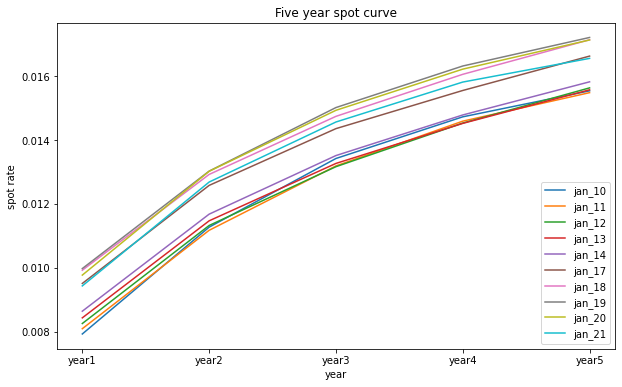

In [25]:
plt.figure(figsize=(10, 6))
plt.xlabel('year')
plt.ylabel('spot rate')
plt.title('Five year spot curve')
lst_year = ['year'+str(i+1) for i in range(5)]
for i in range(len(lst_spotBdate)):
    plt.plot(lst_year, df_spot_4_in[lst_spotBdate[i]], label=lst_date[i])
plt.legend(loc="lower right")

# save first then show
plt.savefig('fig/spot_curve.png', dpi=800)
plt.show()
plt.close()

Caculate the forward rate

In [26]:
def forward_rate(k, r_1, r_2):
    return ((k+1)*r_2-r_1)/k

In [27]:
lst_fBdate = ['forward_'+i for i in lst_date]
df_forward = pd.DataFrame(index=df_spot_4_in.index.values, columns=['coupon'] + lst_fBdate + lst_str_maturity)
df_forward[['coupon']+lst_str_maturity] = df_spot_4_in[['coupon']+lst_str_maturity]
df_forward = df_forward.drop(4)

In [28]:
for d in lst_date:
    
    spotBdate = 'spot_'+d
    fBdate = 'forward_'+d
     
    for i in range(len(df_spot_4_in.index.values)): 

        if i+1 in df_spot_4.index.values:
            r_1 = df_spot_4_in.loc[i, spotBdate]
            r_2 = df_spot_4_in.loc[i+1, spotBdate]
            df_forward.loc[i, fBdate] = forward_rate(i+1, r_1, r_2)

df_forward

,coupon,forward_jan_10,forward_jan_11,forward_jan_12,forward_jan_13,forward_jan_14,forward_jan_17,forward_jan_18,forward_jan_19,forward_jan_20,...,maturity_date_10,maturity_date_11,maturity_date_12,maturity_date_13,maturity_date_14,maturity_date_17,maturity_date_18,maturity_date_19,maturity_date_20,maturity_date_21
0,0.0025,0.014613,0.014251,0.01439,0.014505,0.014714,0.015644,0.015916,0.016072,0.016265,...,2023-01-10,2023-01-11,2023-01-12,2023-01-13,2023-01-14,2023-01-17,2023-01-18,2023-01-19,2023-01-20,2023-01-21
1,0.0025,0.014494,0.014194,0.014084,0.014163,0.014428,0.015241,0.015646,0.016006,0.01588,...,2024-01-10,2024-01-11,2024-01-12,2024-01-13,2024-01-14,2024-01-17,2024-01-18,2024-01-19,2024-01-20,2024-01-21
2,0.0150,0.015157,0.015054,0.014982,0.014935,0.015204,0.015944,0.01649,0.016744,0.016642,...,2025-01-10,2025-01-11,2025-01-12,2025-01-13,2025-01-14,2025-01-17,2025-01-18,2025-01-19,2025-01-20,2025-01-21
3,0.0050,0.015738,0.015701,0.015903,0.01583,0.016076,0.01689,0.017402,0.017426,0.017353,...,2026-01-10,2026-01-11,2026-01-12,2026-01-13,2026-01-14,2026-01-17,2026-01-18,2026-01-19,2026-01-20,2026-01-21


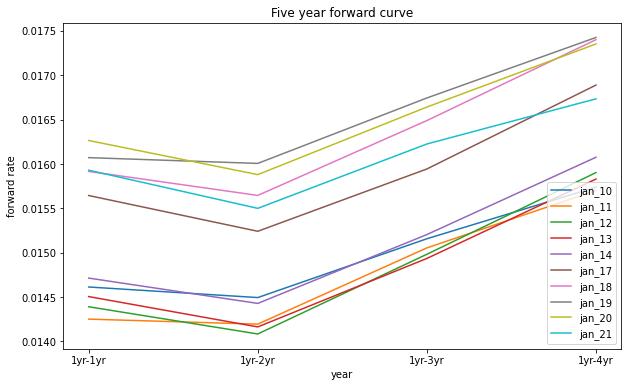

In [29]:
plt.figure(figsize=(10, 6))
plt.xlabel('year')
plt.ylabel('forward rate')
plt.title('Five year forward curve')

lst_forward_year = [str(1)+'yr'+'-'+str(i+1)+'yr' for i in range(4)]

for i in range(len(lst_fBdate)):
    plt.plot(lst_forward_year, df_forward[lst_fBdate[i]], label=lst_date[i])
plt.legend(loc="lower right")

# save first then show
plt.savefig('fig/forward_curve.png', dpi=800)
plt.show()
plt.close()

Intropolate ytm

In [30]:
df_ytm_in = df_ytm.loc[df_ytm.index[(df_ytm['maturity_date'].apply(trunc_datetime) == '2020-09-01')|(
    df_ytm['maturity_date'].apply(trunc_datetime)== '2020-08-01')]]
df_ytm_in.reset_index(inplace=True)
df_ytm_in = df_ytm_in.drop(columns={'index'})
df_ytm_in

,coupon,maturity_date,ytm_jan_10,ytm_jan_11,ytm_jan_12,ytm_jan_13,ytm_jan_14,ytm_jan_17,ytm_jan_18,ytm_jan_19,ytm_jan_20,ytm_jan_21
0,0.0025,2022-08-01,0.006059,0.006256,0.006455,0.006656,0.006859,0.007666,0.008065,0.008093,0.007745,0.007393
1,0.0025,2023-08-01,0.010191,0.010256,0.010393,0.010525,0.010716,0.011589,0.011981,0.012024,0.011981,0.011646
2,0.0150,2024-09-01,0.012809,0.012538,0.012574,0.012726,0.012954,0.013837,0.014146,0.014378,0.014300,0.013911
3,0.0050,2025-09-01,0.014409,0.014244,0.014108,0.014115,0.014380,0.015123,0.015622,0.015949,0.015842,0.015501
4,0.0100,2026-09-01,0.015193,0.015106,0.015176,0.015134,0.015386,0.016167,0.016672,0.016813,0.016726,0.016216


In [31]:
lst_maturity = df_ytm_in['maturity_date'].tolist()
df_ytm_in.drop(columns={'maturity_date'}, inplace=True) 

lst_str_maturity = ['maturity_date_'+str(10+j) for j in range(5)] + ['maturity_date_'+str(12+j) for j in range(5, 10)]

for j in range(len(lst_ytmBdate)):
    ytmBdate = lst_ytmBdate[j]
    
    if j <= 4:
        lst_result = [[datetime.strptime("2023/01/"+str(10+j), '%Y/%m/%d')+relativedelta(years=i)] for i in range(5)]
    else:
        lst_result = [[datetime.strptime("2023/01/"+str(12+j), '%Y/%m/%d')+relativedelta(years=i)] for i in range(5)]
        
    str_maturity = lst_str_maturity[j]
    df_ytm_in = df_ytm_in.join(group_date_2(lst_maturity, lst_result, str_maturity))   
    lst_ytm = df_ytm_in[ytmBdate].tolist()   
    df_ytm_in = df_ytm_in.join(group_spot_2(lst_ytm, ytmBdate))   
    df_ytm_in.drop(columns={ytmBdate}, inplace=True)
    df_ytm_in[ytmBdate] = df_ytm_in.apply(lambda df: interopolation(df['start_date'], df['end_date'], df[str_maturity], 
                                                                df['start_'+ytmBdate], df['end_'+ytmBdate]), axis=1)

    df_ytm_in.drop(columns={'start_'+ytmBdate, 'end_'+ytmBdate}, inplace=True)
    df_ytm_in.drop(columns={'start_date', 'end_date'}, inplace=True)

df_ytm_in    

,coupon,maturity_date_10,ytm_jan_10,maturity_date_11,ytm_jan_11,maturity_date_12,ytm_jan_12,maturity_date_13,ytm_jan_13,maturity_date_14,...,maturity_date_17,ytm_jan_17,maturity_date_18,ytm_jan_18,maturity_date_19,ytm_jan_19,maturity_date_20,ytm_jan_20,maturity_date_21,ytm_jan_21
0,0.0025,2023-01-10,0.007892,2023-01-11,0.008042,2023-01-12,0.008224,2023-01-13,0.008405,2023-01-14,...,2023-01-17,0.009482,2023-01-18,0.009889,2023-01-19,0.009935,2023-01-20,0.009741,2023-01-21,0.009409
1,0.0025,2024-01-10,0.011259,2024-01-11,0.011193,2024-01-12,0.011294,2024-01-13,0.011439,2024-01-14,...,2024-01-17,0.012546,2024-01-18,0.012908,2024-01-19,0.013038,2024-01-20,0.012986,2024-01-21,0.012633
2,0.0150,2025-01-10,0.013383,2025-01-11,0.013155,2025-01-12,0.013133,2025-01-13,0.013236,2025-01-14,...,2025-01-17,0.014323,2025-01-18,0.014708,2025-01-19,0.014981,2025-01-20,0.014895,2025-01-21,0.014530
3,0.0050,2026-01-10,0.014690,2026-01-11,0.014556,2026-01-12,0.014497,2026-01-13,0.014489,2026-01-14,...,2026-01-17,0.015518,2026-01-18,0.016022,2026-01-19,0.016281,2026-01-20,0.016183,2026-01-21,0.015780
4,0.0100,2027-01-10,0.015474,2027-01-11,0.015417,2027-01-12,0.015566,2027-01-13,0.015509,2027-01-14,...,2027-01-17,0.016562,2027-01-18,0.017072,2027-01-19,0.017144,2027-01-20,0.017067,2027-01-21,0.016494


Calcualte Covariance 

In [32]:
df_ytm_in = df_ytm_in.drop(columns=['coupon']+lst_str_maturity)
df_log_ytm = np.log((df_ytm_in)/df_ytm_in.copy().shift(1, axis=1, fill_value=1)).drop(columns=['ytm_jan_10'])
label_lst = ['X_'+str(i+1) for i in range(np.cov(df_log_ytm).shape[0])]
cov_ytm = pd.DataFrame(np.cov(df_log_ytm), index=label_lst, columns=label_lst)
cov_ytm

,X_1,X_2,X_3,X_4,X_5
X_1,0.001389,0.000994,0.000831,0.000755,0.000820
X_2,0.000994,0.000787,0.000699,0.000620,0.000635
X_3,0.000831,0.000699,0.000663,0.000588,0.000562
X_4,0.000755,0.000620,0.000588,0.000546,0.000528
X_5,0.000820,0.000635,0.000562,0.000528,0.000565


In [33]:
df_forward = df_forward.drop(columns=['coupon']+lst_str_maturity)
df_log_forward = np.log((df_forward/df_forward.copy().shift(1, axis=1, fill_value=1)).drop(columns=['forward_jan_10']).astype(float))
label_lst = ['X_'+str(i+1) for i in range(np.cov(df_log_forward).shape[0])]
cov_forward = pd.DataFrame(np.cov(df_log_forward), index=label_lst, columns=label_lst)
cov_forward

,X_1,X_2,X_3,X_4
X_1,0.000612,0.000570,0.000475,0.000505
X_2,0.000570,0.000654,0.000560,0.000523
X_3,0.000475,0.000560,0.000523,0.000512
X_4,0.000505,0.000523,0.000512,0.000585


Calcualte Eigenvalues and Eigenvectors

In [34]:
w_ytm, v_ytm = np.linalg.eigh(cov_ytm)
w_forward, v_forward = np.linalg.eigh(cov_forward)

In [35]:
label_lst = ['V_'+str(i+1) for i in range(cov_ytm.shape[0])]
df_eigen_ytm = pd.DataFrame(v_ytm, columns=label_lst)
df_eigen_ytm.loc['eigenvalue'] = w_ytm
df_eigen_ytm

,V_1,V_2,V_3,V_4,V_5
0,-0.132280,0.316251,-0.099486,-0.723476,-0.590908
1,0.561828,-0.585352,-0.359893,0.063529,-0.456238
2,-0.631854,0.020870,-0.416204,0.512792,-0.405147
3,0.458563,0.621281,0.251289,0.453346,-0.367507
4,-0.239440,-0.413428,0.790068,0.063784,-0.378774
eigenvalue,0.000001,0.000016,0.000044,0.000167,0.003722


In [36]:
label_lst = ['V_'+str(i+1) for i in range(cov_forward.shape[0])]
df_eigen_forward = pd.DataFrame(v_forward, columns=label_lst)
df_eigen_forward.loc['eigenvalue'] = w_forward
df_eigen_forward

,V_1,V_2,V_3,V_4
0,-0.257818,-0.476007,-0.676816,-0.498866
1,0.556989,0.591796,-0.235541,-0.532974
2,-0.708778,0.378689,0.355496,-0.477338
3,0.347746,-0.528951,0.600053,-0.489101
eigenvalue,0.000004,0.000087,0.000113,0.002170
